In [20]:
import numpy as np
import pandas as pd
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium 

##  DATA

In [30]:
hoods=pd.read_csv('/home/vahan/Downloads/Neighbourhoods.csv')
#econ = pd.read_excel('/home/vahan/Downloads/wellbeing-toronto-economics.xlsx')
hoods = hoods[['AREA_SHORT_CODE', 'LONGITUDE', 'LATITUDE']]
econ.rename(columns={'Neighbourhood Id':'AREA_SHORT_CODE'}, inplace=True)
econ = econ[['Neighbourhood', 'AREA_SHORT_CODE', 'Home Prices']]

toronto_df = pd.merge(econ, hoods, how="left", on="AREA_SHORT_CODE")

### Foursquare Data

In [31]:
##foursquare login

CLIENT_ID = 'your Foursquare ID' 
CLIENT_SECRET = 'your Foursquare Secret' 
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

LIMIT = 100
radius = 500 # define radius


Your credentails:
CLIENT_ID: your Foursquare ID
CLIENT_SECRET:your Foursquare Secret


In [51]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [54]:
#get venues for each neighborhood
tor_venues = getNearbyVenues(names=toronto_df['Neighbourhood'],
                                   latitudes=toronto_df['LATITUDE'],
                                   longitudes=toronto_df['LONGITUDE']
                                  )

West Humber-Clairville
Mount Olive-Silverstone-Jamestown
Thistletown-Beaumond Heights
Rexdale-Kipling
Elms-Old Rexdale
Kingsview Village-The Westway
Willowridge-Martingrove-Richview
Humber Heights-Westmount
Edenbridge-Humber Valley
Princess-Rosethorn
Eringate-Centennial-West Deane
Markland Wood
Etobicoke West Mall
Islington-City Centre West
Kingsway South
Stonegate-Queensway
Mimico
New Toronto
Long Branch
Alderwood
Humber Summit
Humbermede
Pelmo Park-Humberlea
Black Creek
Glenfield-Jane Heights
Downsview-Roding-CFB
York University Heights
Rustic
Maple Leaf
Brookhaven-Amesbury
Yorkdale-Glen Park
Englemount-Lawrence
Clanton Park
Bathurst Manor
Westminster-Branson
Newtonbrook West
Willowdale West
Lansing-Westgate
Bedford Park-Nortown
St.Andrew-Windfields
Bridle Path-Sunnybrook-York Mills
Banbury-Don Mills
Victoria Village
Flemingdon Park
Parkwoods-Donalda
Pleasant View
Don Valley Village
Hillcrest Village
Bayview Woods-Steeles
Newtonbrook East
Willowdale East
Bayview Village
Henry Farm
O'

In [58]:
#venues per neighborhood
tor_venues.groupby('Neighbourhood').count().head()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt North,18,18,18,18,18,18
Agincourt South-Malvern West,21,21,21,21,21,21
Alderwood,6,6,6,6,6,6
Annex,28,28,28,28,28,28
Banbury-Don Mills,24,24,24,24,24,24


In [59]:
print('There are {} uniques categories.'.format(len(tor_venues['Venue Category'].unique())))

There are 287 uniques categories.


In [67]:
# one hot encoding//dummy variable
tor_onehot = pd.get_dummies(tor_venues[['Venue Category']], prefix="", prefix_sep="")
tor_onehot['Neighbourhood'] = tor_venues['Neighbourhood'] 
fixed_columns = [tor_onehot.columns[-1]] + list(tor_onehot.columns[:-1])
tor_onehot = tor_onehot[fixed_columns]


In [289]:
#group by neighborhood
tor_grouped = tor_onehot.groupby('Neighbourhood').sum().reset_index()
tor_grouped[.head()]

0    18
1    21
2     6
3    28
4    24
dtype: int64

In [280]:
#Merge toronto_grouped and neighborhood data
tor_full = pd.merge(toronto_df, tor_grouped, how='left', on='Neighbourhood').fillna(0)
tor_full.head()

,Neighbourhood,AREA_SHORT_CODE,Home Prices,LONGITUDE,LATITUDE,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Quad,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,North Indian Restaurant,Office,Organic Grocery,Other Great Outdoors,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pie Shop,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Social Club,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Stat

In [276]:
#correlation matrix, filter for correlation <-0.15, or >.2
high_corr = tor_full.corr()[["Home Prices"]].query('(`Home Prices` >= 0.23)')

#high_corr = high_corr.drop(row_names_remove)
high_corr

,Home Prices
Home Prices,1.000000
Bagel Shop,0.263501
Candy Store,0.238034
College Gym,0.359421
College Quad,0.430248
Liquor Store,0.253851
Playground,0.243628
Pub,0.237198
Trail,0.294946


In [271]:
#choose correlated features
intersection_columns = tor_full.columns & high_corr.index
df_model = tor_full[intersection_columns].fillna(0)
df_model.head()


,Home Prices,Bagel Shop,Candy Store,College Gym,College Quad,Liquor Store,Playground,Pub,Trail
0,317508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,251119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,414216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,392271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,233832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


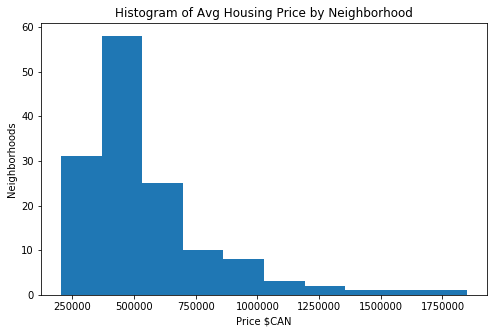

In [272]:
#visualization histogram of home prices
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
#histogram of home prices
df_model['Home Prices'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Avg Housing Price by Neighborhood') # add a title to the histogram
plt.ylabel('Neighborhoods') # add y-label
plt.xlabel('Price $CAN') # add x-label

plt.show()


In [277]:
#train/test

msk = np.random.rand(len(df_model)) < 0.8
train = df_model[msk]
test = df_model[~msk]

In [278]:
#train multiple linear regression model
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(train.drop('Home Prices', axis=1))
y = np.asanyarray(train[['Home Prices']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[ 241252.97920175  887610.84320138  226610.67453598 1028141.26954924
   164177.66669768 -116202.65881286   53328.50985254  100351.2403033 ]]


In [279]:
#prediction
y_hat= regr.predict(test.drop('Home Prices', axis=1))
x_test = np.asanyarray(test.drop('Home Prices', axis=1))
y_test = np.asanyarray(test[['Home Prices']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x_test, y_test))

Residual sum of squares: 75779076268.93
Variance score: -0.12


Clearly multiple linear regression does not yield accurate results. So we will try a combining sum of venues

In [291]:
#add column for sum
tor_grouped = tor_onehot.groupby('Neighbourhood').sum().reset_index()
tor_grouped['venueSum'] = tor_onehot.groupby('Neighbourhood').sum().reset_index().sum(axis=1)
tor_sum = tor_grouped[['Neighbourhood', 'venueSum']]

tor_sum = pd.merge(toronto_df, tor_sum, how='left', on='Neighbourhood').fillna(0)


In [292]:
#train/test split
msk = np.random.rand(len(tor_sum)) < 0.8
train = tor_sum[msk]
test = tor_sum[~msk]

In [294]:
#trainlinear regression model
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['venueSum']])
y = np.asanyarray(train[['Home Prices']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[2397.3852483]]


In [296]:
#prediction
y_hat= regr.predict(test[['Home Prices']])
x_test = np.asanyarray(test[['venueSum']])
y_test = np.asanyarray(test[['Home Prices']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x_test, y_test))

Residual sum of squares: 1936471731888267008.00
Variance score: -0.08
